In [1]:
#Splitea y normaliza las imágenes
import tensorflow as tf
from tensorflow import keras
import pathlib

data_dir = pathlib.Path('dataset')
img_size = (256, 256)
batch_size = 16

# Primer split: TRAIN 70%, TEMP 30%
# image_dataset_from_directory usa label enconding por defecto
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.30,  # el 30% NO ES VALIDATION, es un temp set
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.30,
    subset="validation",   # este es el 30% temporal
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

temp_ds = temp_ds.cache()
val_size = len(temp_ds) // 2
val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

class_names = train_ds.class_names # Nombre de las clases
num_classes = len(class_names)

Found 32529 files belonging to 11 classes.
Using 22771 files for training.
Found 32529 files belonging to 11 classes.
Using 9758 files for validation.


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

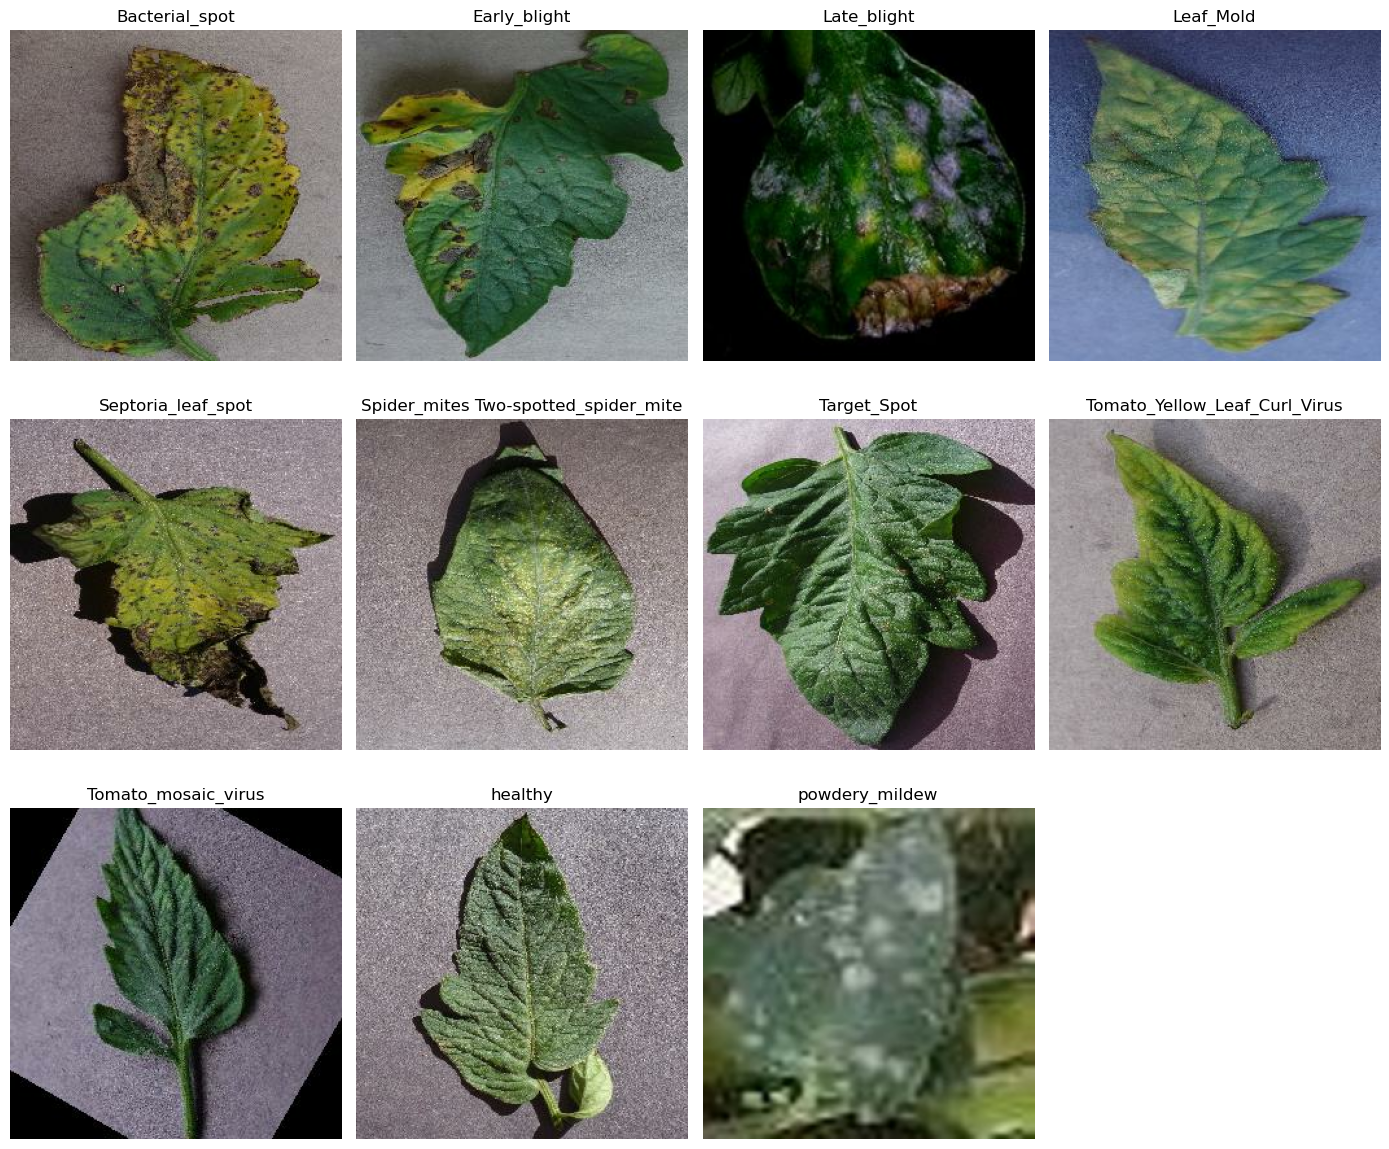

In [3]:
# Mostrar imágenes
import matplotlib.pyplot as plt
import math

samples = {cls: None for cls in class_names}

# Recorremos el dataset hasta completar una muestra por clase
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if samples[class_name] is None:   # si aún no tenemos imagen de esta clase
            samples[class_name] = img
        # si ya tenemos todas las clases, paramos
        if all(v is not None for v in samples.values()):
            break
    if all(v is not None for v in samples.values()):
        break

cols = 4
rows = math.ceil(num_classes / cols)  # = 3 filas si tienes 11 clases

plt.figure(figsize=(14, rows * 4))

# Plot de imágenes
for idx, (cls, img) in enumerate(samples.items()):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(100).map(preprocess, AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess, AUTOTUNE).prefetch(AUTOTUNE)
test_ds  = test_ds.map(preprocess, AUTOTUNE).prefetch(AUTOTUNE)

In [5]:
# Transfer Learning
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=img_size + (3,)
)

base_model.trainable = False  # ← etapa 1: congelado

In [6]:
from tensorflow.keras import layers

inputs = keras.Input(shape=img_size + (3,))

x = keras.applications.efficientnet.preprocess_input(inputs)  # Normalización propia

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 1835s 1s/step - accuracy: 0.3261 - loss: 2.0166 - val_accuracy: 0.6764 - val_loss: 1.2454
Epoch 2/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 1715s 1s/step - accuracy: 0.6506 - loss: 1.2115 - val_accuracy: 0.7539 - val_loss: 0.9410
Epoch 3/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 1704s 1s/step - accuracy: 0.7280 - loss: 0.9578 - val_accuracy: 0.7867 - val_loss: 0.7929
Epoch 4/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 1919s 1s/step - accuracy: 0.7559 - loss: 0.8336 - val_accuracy: 0.8072 - val_loss: 0.7017
Epoch 5/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 1588s 1s/step - accuracy: 0.7800 - loss: 0.7527 - val_accuracy: 0.8215 - val_loss: 0.6399
Epoch 6/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 1579s 1s/step - accuracy: 0.7923 - loss: 0.6927 - val_accuracy: 0.8334 - val_loss: 0.5927
Epoch 7/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 1569s 1s/step - accuracy: 0.8063 - loss: 0.6550 - val_accuracy: 0.8412 - val_loss: 0.5582
Epoch 8/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 1586s 1s/step - accuracy: 0.8171 -

In [9]:
base_model.trainable = True

# Recomiendo descongelar solo las últimas 60 capas:
for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2475s 2s/step - accuracy: 0.7249 - loss: 0.8581 - val_accuracy: 0.8721 - val_loss: 0.4319
Epoch 2/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2431s 2s/step - accuracy: 0.8278 - loss: 0.5340 - val_accuracy: 0.9027 - val_loss: 0.3254
Epoch 3/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2434s 2s/step - accuracy: 0.8626 - loss: 0.4302 - val_accuracy: 0.9168 - val_loss: 0.2634
Epoch 4/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2429s 2s/step - accuracy: 0.8845 - loss: 0.3583 - val_accuracy: 0.9266 - val_loss: 0.2233
Epoch 5/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2437s 2s/step - accuracy: 0.8966 - loss: 0.3138 - val_accuracy: 0.9375 - val_loss: 0.1921
Epoch 6/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2449s 2s/step - accuracy: 0.9123 - loss: 0.2690 - val_accuracy: 0.9463 - val_loss: 0.1677
Epoch 7/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 3826s 3s/step - accuracy: 0.9214 - loss: 0.2420 - val_accuracy: 0.9500 - val_loss: 0.1514
Epoch 8/10
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 2881s 2s/step - accuracy: 0.9317 -

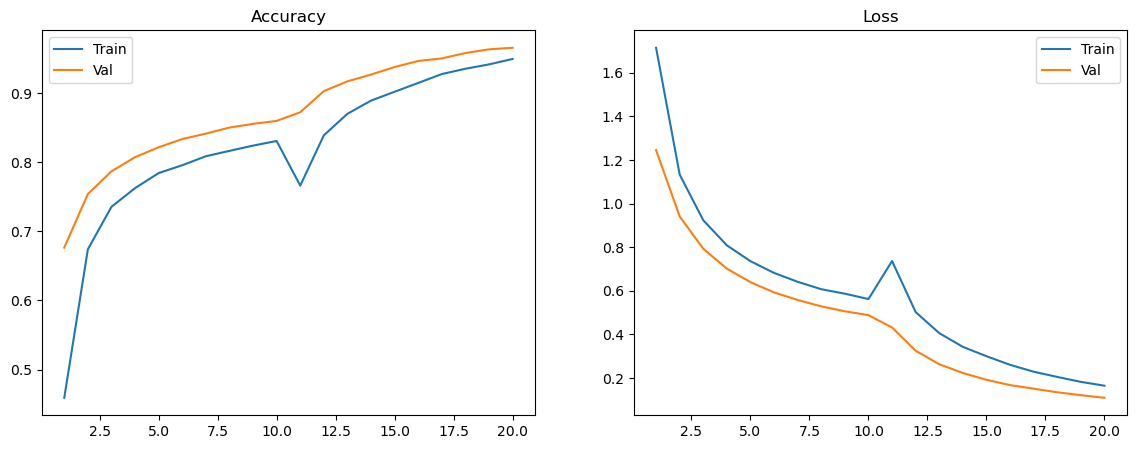

In [10]:
import matplotlib.pyplot as plt

def plot_learning_curves(history1, history2=None):
    acc = history1.history["accuracy"]
    val_acc = history1.history["val_accuracy"]
    loss = history1.history["loss"]
    val_loss = history1.history["val_loss"]

    if history2:
        acc += history2.history["accuracy"]
        val_acc += history2.history["val_accuracy"]
        loss += history2.history["loss"]
        val_loss += history2.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Train")
    plt.plot(epochs, val_acc, label="Val")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Train")
    plt.plot(epochs, val_loss, label="Val")
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_learning_curves(history, history_ft)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/

<Figure size 1000x1000 with 0 Axes>

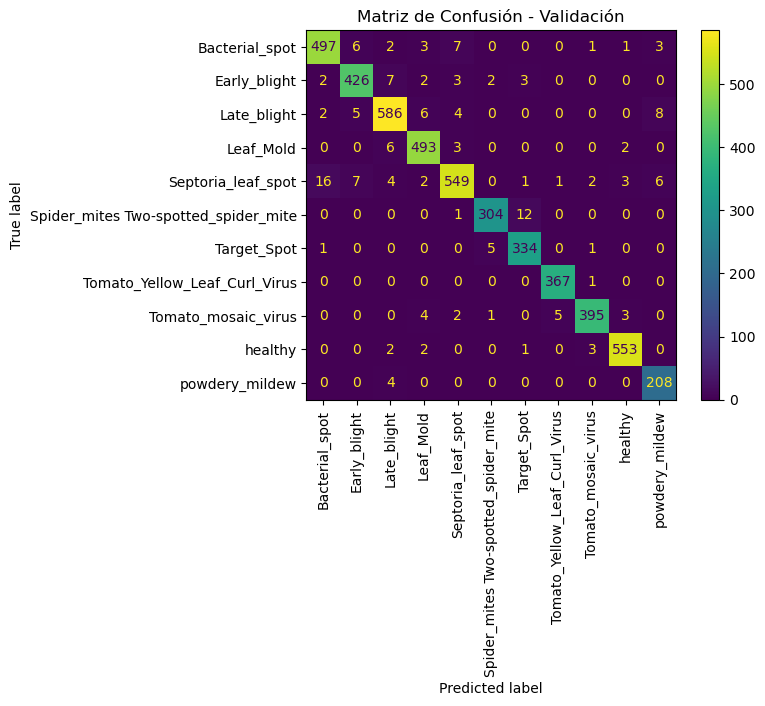

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/

<Figure size 1000x1000 with 0 Axes>

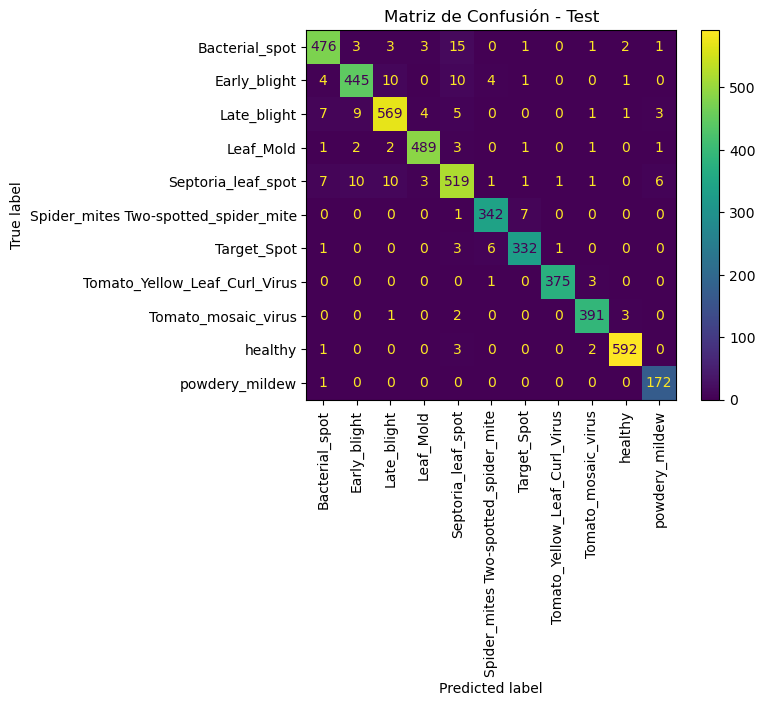

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def evaluate_confusion_matrix(dataset, dataset_name):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

    plt.figure(figsize=(10,10))
    disp.plot(xticks_rotation=90)
    plt.title(f"Matriz de Confusión - {dataset_name}")
    plt.show()

# Validation
evaluate_confusion_matrix(val_ds, "Validación")

# Test
evaluate_confusion_matrix(test_ds, "Test")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..215.0].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..225.31018].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..230.95215].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


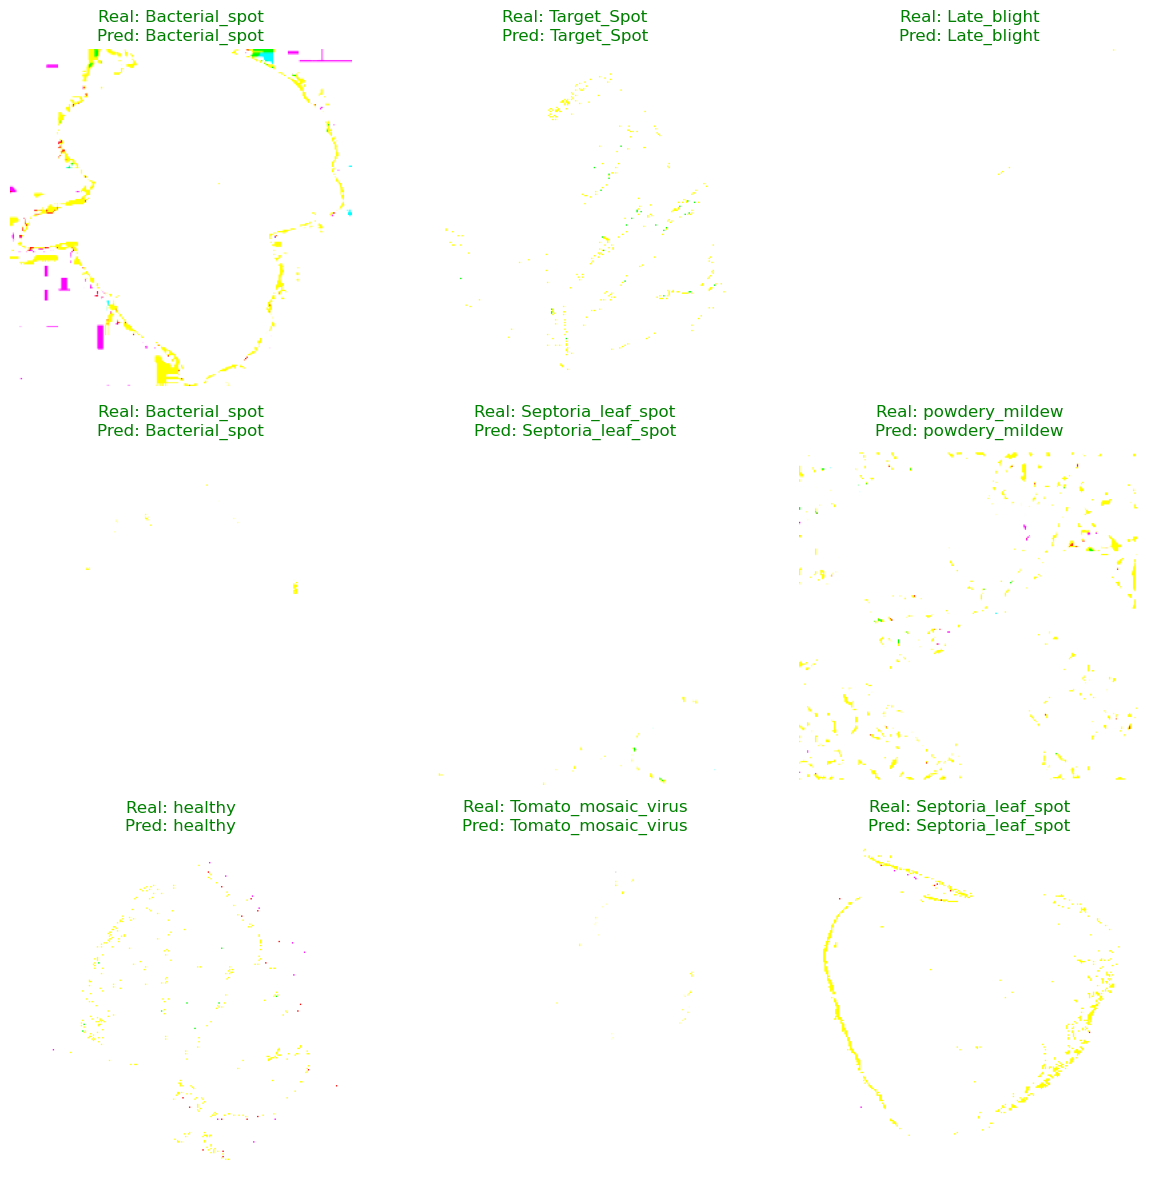

In [12]:
import random

def show_predictions(dataset, num_images=9):
    plt.figure(figsize=(12, 12))
    
    # Obtener un batch aleatorio
    for images, labels in dataset.take(1):
        indices = random.sample(range(len(images)), num_images)

        for i, idx in enumerate(indices):
            img = images[idx]
            true_label = class_names[labels[idx].numpy()]

            pred = model.predict(tf.expand_dims(img, axis=0))
            pred_label = class_names[np.argmax(pred)]

            plt.subplot(3, 3, i + 1)
            plt.imshow(img.numpy())
            color = "green" if pred_label == true_label else "red"
            plt.title(f"Real: {true_label}\nPred: {pred_label}", color=color)
            plt.axis("off")

        plt.tight_layout()
        plt.show()

show_predictions(test_ds, num_images=9)

In [13]:
model.save("modelo_final_efficientnet.keras", save_format="keras")
print("Modelo guardado como modelo_final_efficientnet.keras")

Modelo guardado como modelo_final_efficientnet.keras


In [15]:
model.save("modelo_final_efficientnet.h5")
print("Modelo guardado como modelo_final_efficientnet.h5")

Modelo guardado como modelo_final_efficientnet.h5
